In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import integrate

import matplotlib.pylab as pylab

%config InlineBackend.figure_format = 'retina' # higher res notebook output

This notebook constructs a 6-panel figure (3x2) that plots (left column) the filter weights and (right column) the Fourier transform of the filter. The first row shows a boxcar filter, the second shows a Gaussian filter, and the last shows the "taper" filter. All filters are designed to reduce the length scales by a factor of 8 compared to the grid scale. In each panel the are multiple lines, each corresponding to a different degree of the filter $N$=3, 5, 11. 

The following block defines a function to solve the optimization problem for the filter polynomial $p(s)$, and another function to get the corresponding kernel weights on an equispaced grid. Both functions assume a grid spacing of 1 (nondimensional).

In [2]:
def filterSpec(N,Fk):
    """
    Inputs: 
    N is the number of total steps in the filter
    F is the target filter F(s) (\hat{G}_t(s) in the paper)
    
    Outputs:
    NL is the number of Laplacian steps
    sL is s_i for the Laplacian steps; units of sL are one over the units of dxMin and Lf, squared
    NB is the number of Biharmonic steps
    sB is s_i for the Biharmonic steps; units of sB are one over the units of dxMin and Lf, squared
    p is the Chebyshev basis coefficients of the filter p(s)
    """
    # Code only works for N>2
    if N <= 2:
        print("Code requires N>2")
        return 
    # First set up the mass matrix for the Galerkin basis from Shen (SISC95)
    M = (np.pi/2)*(2*np.eye(N-1) - np.diag(np.ones(N-3),2) - np.diag(np.ones(N-3),-2))
    M[0,0] = 3*np.pi/2
    # The range of wavenumbers is 0<=|k|<=pi/dxMin. Nyquist here is for a 1D grid. 
    # Per the notes, define s=k^2.
    # Need to rescale to t in [-1,1]: t = (2/sMax)*s -1; s = sMax*(t+1)/2
    sMax = np.pi**2
    F = lambda z: Fk(np.sqrt(sMax*(z+1)/2))
    # Compute inner products of Galerkin basis with target
    b = np.zeros(N-1)
    points, weights = np.polynomial.chebyshev.chebgauss(N+1)
    for i in range(N-1):
        tmp = np.zeros(N+1)
        tmp[i] = 1
        tmp[i+2] = -1
        phi = np.polynomial.chebyshev.chebval(points,tmp)
        b[i] = np.sum(weights*phi*(F(points)-((1-points)/2 + F(1)*(points+1)/2)))
    # Get polynomial coefficients in Galerkin basis
    cHat = np.linalg.solve(M,b)
    # Convert back to Chebyshev basis coefficients
    p = np.zeros(N+1)
    p[0] = cHat[0] + (1+F(1))/2
    p[1] = cHat[1] - (1-F(1))/2
    for i in range(2,N-1):
        p[i] = cHat[i] - cHat[i-2]
    p[N-1] = -cHat[N-3]
    p[N] = -cHat[N-2]
    # Get roots of the polynomial
    r = np.polynomial.chebyshev.chebroots(p)
    # convert back to s in [0,sMax]
    s = (sMax/2)*(r+1)
    # Separate out the real and complex roots
    NL = np.size(s[np.where(np.abs(np.imag(r)) < 1E-12)]) 
    sL = np.real(s[np.where(np.abs(np.imag(r)) < 1E-12)])
    NB = (N - NL)//2
    sB_re,indices = np.unique(np.real(s[np.where(np.abs(np.imag(r)) > 1E-12)]),return_index=True)
    sB_im = np.imag(s[np.where(np.abs(np.imag(r)) > 1E-12)])[indices]
    sB = sB_re + sB_im*1j
    return NL,sL,NB,sB,p

def getKernel(NL,sL,NB,sB):
    """
    Inputs: The outputs of filterSpec
    
    Outputs:
    g is the discrete convolution kernel
    """
    L3 = np.array([1,-2,1]) 
    L5 = np.array([0,1,-2,1,0])
    B = np.array([1,-4,6,-4,1]) 
    I3 = np.array([0,1,0])
    I5 = np.array([0,0,1,0,0])
    g = 1
    for i in range(NL):
        g = np.convolve(I3 + (1/sL[i])*L3,g)
    for i in range(NB):
        g = np.convolve(I5 + (2*np.real(sB[i])/np.abs(sB[i])**2)*L5 + (1/np.abs(sB[i])**2)*B, g)
    return g

In [3]:
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
# Here you can adust the colors that the plot command will cycle through to your liking. More info here: https://matplotlib.org/3.1.1/tutorials/intermediate/color_cycle.html

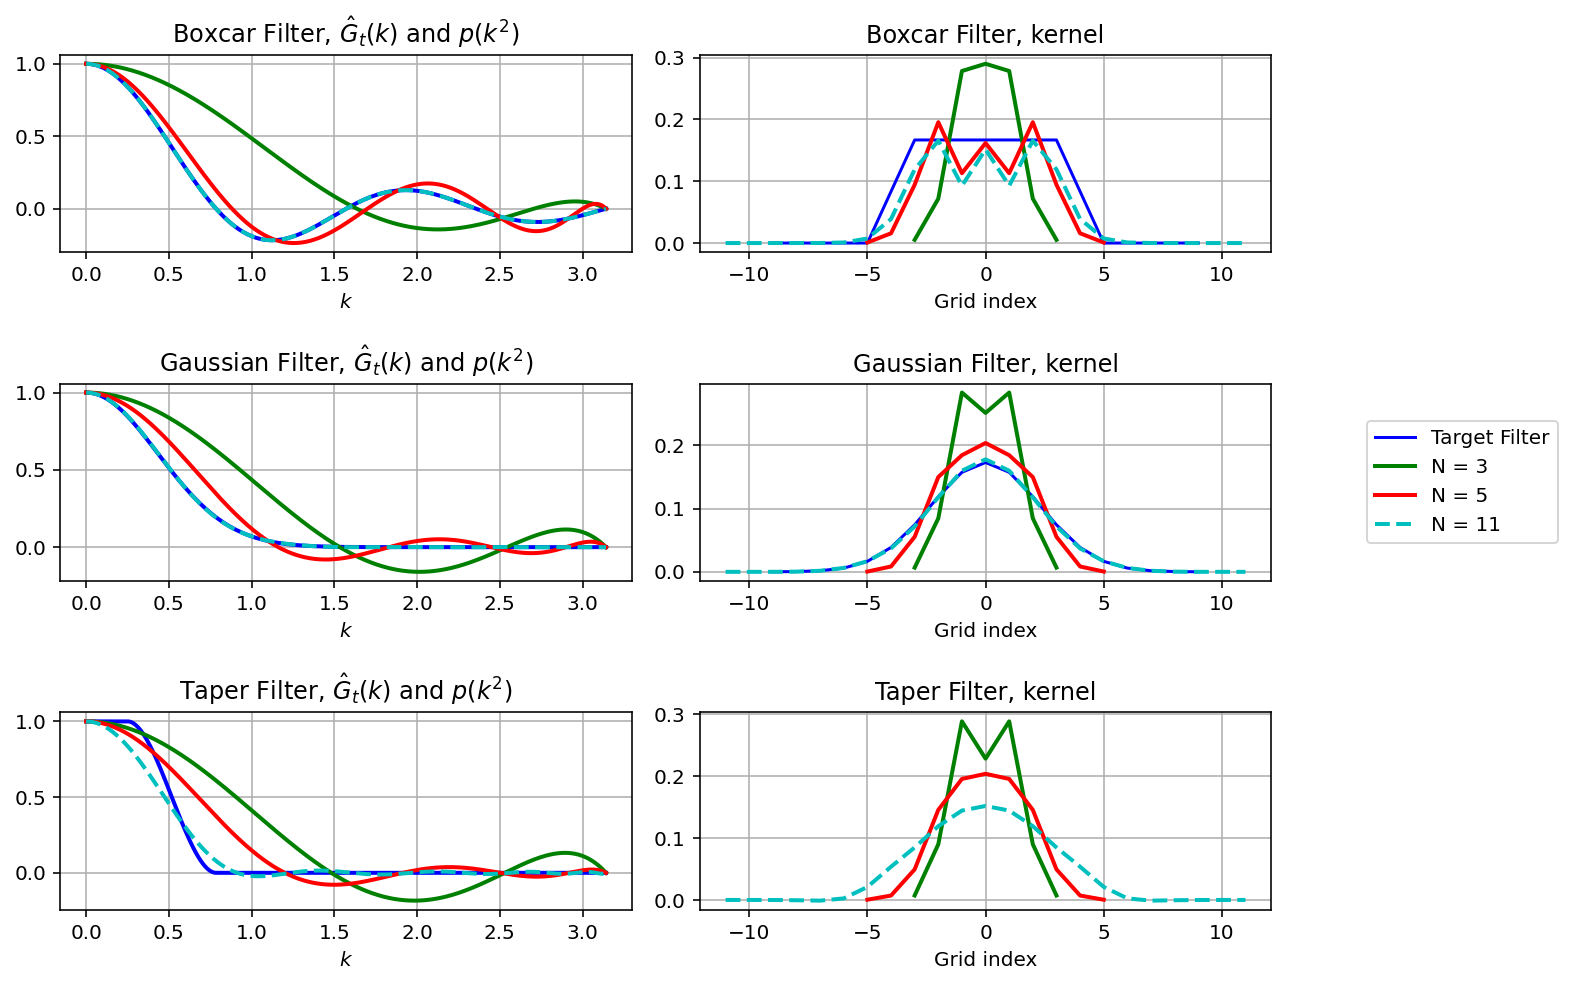

In [6]:
# set up figure with subplots
# Instead of messing with the fonts, I would just reduce the figure size to your liking.
# This assumes that the file will be saved as vector and can thus be scaled anyways.
fig, axarr = plt.subplots(ncols=2, nrows=3, figsize=[11, 7])


# Target filter = boxcar of width 8
FB = lambda z: np.sinc(z*4/np.pi) 

sMax = np.pi**2
x = np.linspace(-1,1,10000)
k = np.sqrt((sMax/2)*(x+1))

N = 3
NL,sL,NB,sB,p3 = filterSpec(N,FB)
g3 = getKernel(NL,sL,NB,sB)

N = 5
NL,sL,NB,sB,p5 = filterSpec(N,FB)
g5 = getKernel(NL,sL,NB,sB)

N = 11
NL,sL,NB,sB,p11 = filterSpec(N,FB)
g11 = getKernel(NL,sL,NB,sB)

# `axarr` can be indexed like a normal array to target a panel of the figure!
axarr[0,0].plot(k,FB(k),k,np.polynomial.chebyshev.chebval(x,p3),k,np.polynomial.chebyshev.chebval(x,p5),k,np.polynomial.chebyshev.chebval(x,p11),'--', linewidth=2)



axarr[0,1].plot(np.arange(-9,10),(1/6)*np.array([0,0,0,0,0,.5,1,1,1,1,1,1,1,.5,0,0,0,0,0]))
axarr[0,1].plot(np.arange(-3,4),g3,np.arange(-5,6),g5,np.arange(-N,N+1),g11,'--', linewidth=2)



# Target filter is Gaussian with standard deviation set to match the boxcar of width 8
FG = lambda z: np.exp(-(8/3)*(z**2)) 
g0 = np.exp(-.5*(np.arange(-9,10)*np.sqrt(3)/4)**2)
g0 = g0/np.sum(g0)

N = 3
NL,sL,NB,sB,p3 = filterSpec(N,FG)
g3 = getKernel(NL,sL,NB,sB)

N = 5
NL,sL,NB,sB,p5 = filterSpec(N,FG)
g5 = getKernel(NL,sL,NB,sB)

N = 11
NL,sL,NB,sB,p11 = filterSpec(N,FG)
g11 = getKernel(NL,sL,NB,sB)


axarr[1,0].plot(k,FG(k),k,np.polynomial.chebyshev.chebval(x,p3),k,np.polynomial.chebyshev.chebval(x,p5),k,np.polynomial.chebyshev.chebval(x,p11),'--', linewidth=2)

axarr[1,1].plot(np.arange(-9,10),g0)
axarr[1,1].plot(np.arange(-3,4),g3,np.arange(-5,6),g5,np.arange(-N,N+1),g11,'--', linewidth=2)

# Target filter is taper with shape set to match the boxcar of width 8
FT = interpolate.PchipInterpolator(np.array([0,1/4,np.pi/4,np.pi]),np.array([1,1,0,0]))

N = 3
NL,sL,NB,sB,p3 = filterSpec(N,FT)
g3 = getKernel(NL,sL,NB,sB)

N = 5
NL,sL,NB,sB,p5 = filterSpec(N,FT)
g5 = getKernel(NL,sL,NB,sB)

N = 11
NL,sL,NB,sB,p11 = filterSpec(N,FT)
g11 = getKernel(NL,sL,NB,sB)

axarr[2,0].plot(k,FT(k),k,np.polynomial.chebyshev.chebval(x,p3),k,np.polynomial.chebyshev.chebval(x,p5),k,np.polynomial.chebyshev.chebval(x,p11),'--', linewidth=2)

# simple fix for the colors: Plot an empty dummy kernel first
axarr[2,1].plot(np.arange(-3,4),np.ones_like(g3) * np.nan, np.arange(-3,4),g3,np.arange(-5,6),g5,np.arange(-N,N+1),g11,'--', linewidth=2)


# tune the labels

# fig.suptitle('A big title for the whole figure') # Probably don't need this

# You can index a single axis like before
axarr[0,0].set_title('Boxcar Filter, $\hat{G}_t(k)$ and $p(k^2)$')
axarr[0,1].set_title('Boxcar Filter, kernel')
axarr[1,0].set_title('Gaussian Filter, $\hat{G}_t(k)$ and $p(k^2)$')
axarr[1,1].set_title('Gaussian Filter, kernel')
axarr[2,0].set_title('Taper Filter, $\hat{G}_t(k)$ and $p(k^2)$')
axarr[2,1].set_title('Taper Filter, kernel')

# One more suggestion to make the plots more readable
axarr[0,0].grid()
axarr[1,0].grid()
axarr[2,0].grid()
axarr[0,1].grid()
axarr[1,1].grid()
axarr[2,1].grid()

# or you can loop over a slice of the array
for ax in axarr[:,0]:
    #ax.set_ylabel('Left column ylabel')
    ax.set_xlabel('$k$')
    
for ax in axarr[:,1]:
    #ax.set_ylabel('Right column ylabel')
    ax.set_xlabel('Grid index')
    
# single legend for all plots
axarr[1,1].legend(['Target Filter', 'N = 3', 'N = 5', 'N = 11'], bbox_to_anchor=(1.15, 0.5), loc='center left', ncol=1)
# see https://stackoverflow.com/a/43439132 for more options
    
plt.tight_layout()

# Just in case, this is how to save a vector graphic
#fig.savefig('Figure1.pdf')